# Segmenting and Clustering Neighborhoods in Toronto

## Importing Libraries

In [1]:
# import all necessary libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from bs4 import BeautifulSoup
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
import requests
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M#Toronto_-_103_FSAs').text

## Part 1 : Web scraping is using the BeautifulSoup package

In [3]:
soup = BeautifulSoup(website_url, 'html.parser')

In [4]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
      # Create three columns named as "PostalCode","Borough" & "Neighborhood"
        cell['PostalCode'] = row.p.text[:3] # store only first three letter from the test of <p> tab.(Ex: M3A )
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

df=pd.DataFrame(table_contents)
# compress some big borough name by smaller one
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

### Data Pre Processing

In [5]:
# droping rows having "Not assigned"
df_dropna = df.dropna()
empty = 'Not assigned'
df_dropna = df_dropna[(df_dropna.PostalCode != empty ) & (df_dropna.Borough != empty) & (df_dropna.Neighborhood != empty)].reset_index(drop=True)

In [6]:
# Checking missing values
df_dropna.isnull().sum()

PostalCode      0
Borough         0
Neighborhood    0
dtype: int64

In [7]:
# Check if we still have any Neighborhoods that are Not Assigned
df_dropna.loc[df_dropna['Borough'].isin(["Not assigned"])]

Empty DataFrame
Columns: [PostalCode, Borough, Neighborhood]
Index: []

In [8]:
df = df_dropna
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

In [9]:
# shape of dataframe
df.shape

(103, 3)

In [10]:
# Cleaned Data in csv format
df.to_csv('Neighborhoods in Toronto.csv')

## Part 2 : To build a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data

In [11]:
# get the latitude and the longitude coordinates of each Postal code
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

In [12]:
# Merging the Data
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [13]:
# lets find out how many neighborhoods in each borough
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto            9
Downtown Toronto          17
Downtown Toronto Stn A     1
East Toronto               4
East Toronto Business      1
East York                  4
East York/East Toronto     1
Etobicoke                 11
Etobicoke Northwest        1
Mississauga                1
North York                24
Queen's Park               1
Scarborough               17
West Toronto               6
York                       5
Name: Neighborhood, dtype: int64

## Data Visualization of all Borough present in Toronto

In [14]:
df_toronto = df
df_toronto.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [15]:
# Create a list and store all unique borough names
boroughs = df_toronto['Borough'].unique().tolist()

In [16]:
# Obtain the Latitude and Longitude of Toronto by taking mean of Latitude/Longitude of all postal code
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165047


In [17]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [18]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
    
map_toronto

## Using Foursquare API to get the top 150 venues that are in Lawrence Park within a radius of 500 meters

In [19]:
CLIENT_ID = 'HVTCMEB4C5WADHXRKQN1X5I4WHHG4N3ULOTY1FH5SSOO0SNE' # your Foursquare ID
CLIENT_SECRET = '3KRMF32OQ0JHTWQEKMVB0AY5KU1MTVDBW5CJRKINI0CKHHNW' # your Foursquare Secret
VERSION = 20200514 # Foursquare API version

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 150 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [22]:
toronto_venues.tail()

Neighborhood  \
2144  Mimico NW, The Queensway West, South of Bloor,...   
2145  Mimico NW, The Queensway West, South of Bloor,...   
2146  Mimico NW, The Queensway West, South of Bloor,...   
2147  Mimico NW, The Queensway West, South of Bloor,...   
2148  Mimico NW, The Queensway West, South of Bloor,...   

      Neighborhood Latitude  Neighborhood Longitude  \
2144              43.628841              -79.520999   
2145              43.628841              -79.520999   
2146              43.628841              -79.520999   
2147              43.628841              -79.520999   
2148              43.628841              -79.520999   

                                      Venue  Venue Latitude  Venue Longitude  \
2144                Jim & Maria's No Frills       43.631152       -79.518617   
2145  Koala Tan Tanning Salon & Sunless Spa       43.631370       -79.519006   
2146                      Once Upon A Child       43.631075       -79.518290   
2147                   Kingsway Boxing Club       43.627254       -79.526684   
2148                           Burrito Boyz       43.626657       -79.526349   

     Venue Category  
2144  Grocery Store  
2145  Tanning Salon  
2146     Kids Store  
2147            Gym  
2148  Burrito Place

In [23]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Agincourt                                                               4   
Alderwood, Long Branch                                                  8   
Bathurst Manor, Wilson Heights, Downsview North                        23   
Bayview Village                                                         4   
Bedford Park, Lawrence Manor East                                      23   
Berczy Park                                                            58   
Birch Cliff, Cliffside West                                             4   
Brockton, Parkdale Village, Exhibition Place                           25   
CN Tower, King and Spadina, Railway Lands, Harb...                     18   
Caledonia-Fairbanks                                                     4   
Cedarbrae                                                               9   
Central Bay Street                                                     68   
Christie                                                               15   
Church and Wellesley                                                   78   
Clairville, Humberwood, Woodbine Downs, West Hu...                      5   
Clarks Corners, Tam O'Shanter, Sullivan                                12   
Cliffside, Cliffcrest, Scarborough Village West                         2   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             36   
Davisville North                                                        8   
Del Ray, Mount Dennis, Keelsdale and Silverthorn                        5   
Don Mills North                                                         6   
Don Mills South                                                        19   
Dorset Park, Wexford Heights, Scarborough Town ...                      8   
Downsview Central                                                       4   
Downsview East                                                          3   
Downsview Northwest                                                     4   
Downsview West                                                          6   
Dufferin, Dovercourt Village                                           16   
Enclave of L4W                                                         14   
Enclave of M4L                                                         15   
Enclave of M5E                                                         98   
Eringate, Bloordale Gardens, Old Burnhamthorpe,...                      7   
Fairview, Henry Farm, Oriole                                           67   
First Canadian Place, Underground city                                100   
Forest Hill North & West                                                4   
Garden District, Ryerson                                              100   
Glencairn                                                               4   
Golden Mile, Clairlea, Oakridge                                         9   
Guildwood, Morningside, West Hill                                       8   
Harbourfront East, Union Station, Toronto Islands                     100   
High Park, The Junction South                                          24   
Hillcrest Village                                                       5   
Humber Summit                                                           3   
Humberlea, Emery                                                        2   
Humewood-Cedarvale                                                      5   
India Bazaar, The Beaches West                                         20   
Kennedy Park, Ionview, East Birchmount Park                             4   
Kensington Market, Chinatown, Grange Park                              67   
Kingsview Village, St. Phillips, Martin Grove G...                      4   
Lawrence Manor, Lawrence Heights                

### Unique venues in all neighborhood 

In [24]:
print('There are {} uniques vanue categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 278 uniques vanue categories.


In [25]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Park' 'Fast Food Restaurant' 'Food & Drink Shop' 'Hockey Arena'
 'Coffee Shop' 'Portuguese Restaurant' 'Intersection' 'Pizza Place'
 'Bakery' 'Distribution Center' 'Restaurant' 'Spa' 'Gym / Fitness Center'
 'Historic Site' 'Chocolate Shop' 'Pub' 'Farmers Market'
 'Performing Arts Venue' 'Breakfast Spot' 'Dessert Shop'
 'Mexican Restaurant' 'French Restaurant' 'Theater' 'Yoga Studio'
 'Shoe Store' 'Event Space' 'Café' 'Asian Restaurant' 'Electronics Store'
 'Art Gallery' 'Bank' 'Beer Store' 'Hotel' 'Wine Shop' 'Sushi Restaurant'
 'Antique Shop' 'Boutique' 'Furniture / Home Store'
 'Vietnamese Restaurant' 'Clothing Store' 'Accessories Store'
 'Miscellaneous Shop' 'Italian Restaurant' 'Beer Bar' 'Creperie'
 'Burrito Place' 'Fried Chicken Joint' 'Hobby Shop' 'Diner'
 'Japanese Restaurant' 'Smoothie Shop' 'Sandwich Place' 'Gym'
 'College Auditorium' 'Bar' 'College Cafeteria' 'Caribbean Restaurant'
 'Baseball Field' 'Gastropub' 'Pharmacy' 'Pet Store' 'Flea Market'


## Data Analysis

In [26]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2149, 279)


Neighborhoods  Accessories Store  Airport  Airport Food Court  \
0         Parkwoods                  0        0                   0   
1         Parkwoods                  0        0                   0   
2         Parkwoods                  0        0                   0   
3  Victoria Village                  0        0                   0   
4  Victoria Village                  0        0                   0   

   Airport Gate  Airport Lounge  Airport Service  Airport Terminal  \
0             0               0                0                 0   
1             0               0                0                 0   
2             0               0                0                 0   
3             0               0                0                 0   
4             0               0                0                 0   

   American Restaurant  Antique Shop  Aquarium  Art Gallery  Art Museum  \
0                    0             0         0            0           0   
1                    0             0         0            0           0   
2                    0             0         0            0           0   
3                    0             0         0            0           0   
4                    0             0         0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                    0                 0                   0            0   
1                    0                 0                   0            0   
2                    0                 0                   0            0   
3                    0                 0                   0            0   
4                    0                 0                   0            0   

   Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0              0          0           0           0       0     0    0   
1              0          0           0           0       0     0    0   
2              0          0           0           0       0     0    0   
3              0          0           0           0       0     0    0   
4              0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 0                   0   

   Beach  Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  \
0      0                0         0           0                   0   
1      0                0         0           0                   0   
2      0                0         0           0                   0   
3      0                0         0           0                   0   
4      0                0         0           0                   0   

   Bike Shop  Bistro  Boat or Ferry  Bookstore  Boutique  \
0          0       0              0          0         0   
1          0       0              0          0         0   
2          0       0              0          0         0   
3          0       0              0          0         0   
4          0       0              0          0         0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                     0               0        0            0   
1                     0               0        0            0   
2                     0               0        0            0   
3                     0               0        0            0   
4                     0               0        0            0   

   Bubble Tea Shop  Building  Burger Joint  Burrito Place  Bus Line  \
0                0         0             0              0         0   
1              

In [27]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index() 

print(to_grouped.shape)
to_grouped.head()

(98, 279)


Neighborhoods  Accessories Store  \
0                                        Agincourt                0.0   
1                           Alderwood, Long Branch                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                  Bayview Village                0.0   
4                Bedford Park, Lawrence Manor East                0.0   

   Airport  Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0      0.0                 0.0           0.0             0.0              0.0   
1      0.0                 0.0           0.0             0.0              0.0   
2      0.0                 0.0           0.0             0.0              0.0   
3      0.0                 0.0           0.0             0.0              0.0   
4      0.0                 0.0           0.0             0.0              0.0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0               0.0             0.000000           0.0       0.0          0.0   
1               0.0             0.000000           0.0       0.0          0.0   
2               0.0             0.000000           0.0       0.0          0.0   
3               0.0             0.000000           0.0       0.0          0.0   
4               0.0             0.043478           0.0       0.0          0.0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0         0.0                  0.0               0.0                 0.0   
1         0.0                  0.0               0.0                 0.0   
2         0.0                  0.0               0.0                 0.0   
3         0.0                  0.0               0.0                 0.0   
4         0.0                  0.0               0.0                 0.0   

   Auto Garage  Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  \
0          0.0            0.0        0.0         0.0         0.0     0.0   
1          0.0            0.0        0.0         0.0         0.0     0.0   
2          0.0            0.0        0.0         0.0         0.0     0.0   
3          0.0            0.0        0.0         0.0         0.0     0.0   
4          0.0            0.0        0.0         0.0         0.0     0.0   

       Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0  0.000000  0.0             0.0               0.0               0.0   
1  0.000000  0.0             0.0               0.0               0.0   
2  0.086957  0.0             0.0               0.0               0.0   
3  0.250000  0.0             0.0               0.0               0.0   
4  0.000000  0.0             0.0               0.0               0.0   

   Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  Beer Store  \
0                 0.0    0.0              0.0       0.0         0.0   
1                 0.0    0.0              0.0       0.0         0.0   
2                 0.0    0.0              0.0       0.0         0.0   
3                 0.0    0.0              0.0       0.0         0.0   
4                 0.0    0.0              0.0       0.0         0.0   

   Belgian Restaurant  Bike Shop  Bistro  Boat or Ferry  Bookstore  Boutique  \
0                 0.0        0.0     0.0            0.0        0.0       0.0   
1                 0.0        0.0     0.0            0.0        0.0       0.0   
2                 0.0        0.0     0.0            0.0        0.0       0.0   
3                 0.0        0.0     0.0            0.0        0.0       0.0   
4                 0.0        0.0     0.0            0.0        0.0       0.0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                   0.0            0.25      0.0     0.000000   
1                   0.0            0.00      0.0     0.000000   
2                   0.0            0.00      0.0     0.043478   
3                   0.0            0.00      0.0     0.000000   
4                   0.0            0.00     

In [28]:
ita = to_grouped[["Neighborhoods","Italian Restaurant"]]
ita.head()

Neighborhoods  Italian Restaurant
0                                        Agincourt            0.000000
1                           Alderwood, Long Branch            0.000000
2  Bathurst Manor, Wilson Heights, Downsview North            0.000000
3                                  Bayview Village            0.000000
4                Bedford Park, Lawrence Manor East            0.086957

In [29]:
# rename column "Neighborhoods" to "Neighborhood"
ita = ita.rename(columns={'Neighborhoods':'Neighborhood'})

## Clustering

#### Finding best k value

In [30]:
X = ita.drop(['Neighborhood'], axis=1)

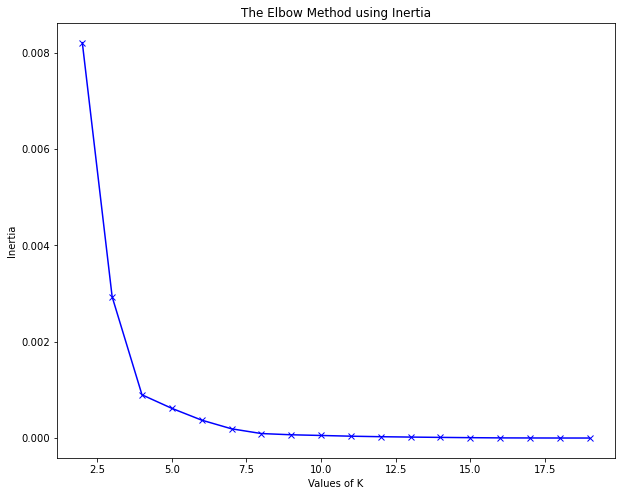

In [31]:
plt.figure(figsize=[10, 8])
inertia=[]
range_val=range(2,20)
for i in range_val:
  kmean=KMeans(n_clusters=i)
  kmean.fit_predict(X)
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [32]:
k = 4

toronto_grouped_clustering = ita.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 2, 3, 0, 1, 0, 0])

In [33]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3])

In [34]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = ita.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [35]:
to_merged.head()

Neighborhood  Italian Restaurant  \
0                                        Agincourt            0.000000   
1                           Alderwood, Long Branch            0.000000   
2  Bathurst Manor, Wilson Heights, Downsview North            0.000000   
3                                  Bayview Village            0.000000   
4                Bedford Park, Lawrence Manor East            0.086957   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               2

In [36]:

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(2149, 9)


Neighborhood  Italian Restaurant  Cluster Labels  \
0               Agincourt                 0.0               0   
0               Agincourt                 0.0               0   
0               Agincourt                 0.0               0   
0               Agincourt                 0.0               0   
1  Alderwood, Long Branch                 0.0               0   

   Neighborhood Latitude  Neighborhood Longitude  \
0              43.794200              -79.262029   
0              43.794200              -79.262029   
0              43.794200              -79.262029   
0              43.794200              -79.262029   
1              43.602414              -79.543484   

                              Venue  Venue Latitude  Venue Longitude  \
0       Panagio's Breakfast & Lunch       43.792370       -79.260203   
0                          Twilight       43.791999       -79.258584   
0                     El Pulgarcito       43.792648       -79.259208   
0                   Commander Arena       43.794867       -79.267989   
1  Il Paesano Pizzeria & Restaurant       43.601280       -79.545028   

              Venue Category  
0             Breakfast Spot  
0                     Lounge  
0  Latin American Restaurant  
0               Skating Rink  
1                Pizza Place

In [37]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.tail()

(2149, 9)


Neighborhood  Italian Restaurant  \
53                           Little Portugal, Trinity             0.02381   
53                           Little Portugal, Trinity             0.02381   
53                           Little Portugal, Trinity             0.02381   
53                           Little Portugal, Trinity             0.02381   
40  Harbourfront East, Union Station, Toronto Islands             0.02000   

    Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
53               3              43.647927              -79.419750   
53               3              43.647927              -79.419750   
53               3              43.647927              -79.419750   
53               3              43.647927              -79.419750   
40               3              43.640816              -79.381752   

                     Venue  Venue Latitude  Venue Longitude  \
53    Frankie's Bar & Cafe       43.644290       -79.418481   
53  BYOB Cocktail Emporium       43.644447       -79.417757   
53  Trinity Bellwoods Park       43.647072       -79.413756   
53                 Hanmoto       43.649505       -79.422768   
40               Starbucks       43.643090       -79.383071   

        Venue Category  
53               Diner  
53  Miscellaneous Shop  
53                Park  
53    Asian Restaurant  
40         Coffee Shop

In [38]:
to_merged['Venue Category'].value_counts()['Italian Restaurant']


42

##  Visualize Clustering 

In [39]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i+x+(i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

In [40]:
ita["Cluster Labels"] = kmeans.labels_
ita.head()

Neighborhood  Italian Restaurant  \
0                                        Agincourt            0.000000   
1                           Alderwood, Long Branch            0.000000   
2  Bathurst Manor, Wilson Heights, Downsview North            0.000000   
3                                  Bayview Village            0.000000   
4                Bedford Park, Lawrence Manor East            0.086957   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               2

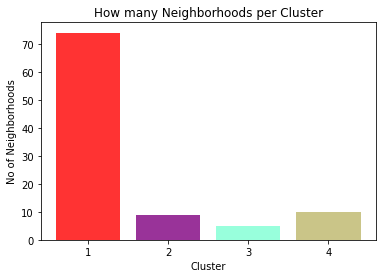

In [41]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [42]:
# How many neighborhoods in each cluster
ita['Cluster Labels'].value_counts()

0    74
3    10
1     9
2     5
Name: Cluster Labels, dtype: int64

## Analysis of each Cluster
#### Cluster 1 : Purple

In [43]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

Borough                      Neighborhood
0        North York                         Parkwoods
1        North York                  Victoria Village
2  Downtown Toronto         Regent Park, Harbourfront
3        North York  Lawrence Manor, Lawrence Heights
4      Queen's Park     Ontario Provincial Government

In [44]:
cluster1=to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1.head()

Borough      Neighborhood  Italian Restaurant  Cluster Labels  \
0  North York         Parkwoods                 0.0               0   
1  North York         Parkwoods                 0.0               0   
2  North York         Parkwoods                 0.0               0   
3  North York  Victoria Village                 0.0               0   
4  North York  Victoria Village                 0.0               0   

   Neighborhood Latitude  Neighborhood Longitude  \
0              43.753259              -79.329656   
1              43.753259              -79.329656   
2              43.753259              -79.329656   
3              43.725882              -79.315572   
4              43.725882              -79.315572   

                                       Venue  Venue Latitude  Venue Longitude  \
0                              Variety Store       43.751974       -79.333114   
1                                        KFC       43.754387       -79.333021   
2                            Brookbanks Park       43.751976       -79.332140   
3                                 Pizza Nova       43.725824       -79.312860   
4  Eglinton Ave E & Sloane Ave/Bermondsey Rd       43.726086       -79.313620   

         Venue Category  
0     Food & Drink Shop  
1  Fast Food Restaurant  
2                  Park  
3           Pizza Place  
4          Intersection

#### Cluster 2 : Red

In [45]:
cluster2 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2.head()

Borough Neighborhood  Italian Restaurant  Cluster Labels  \
0  Downtown Toronto     Christie            0.066667               2   
1  Downtown Toronto     Christie            0.066667               2   
2  Downtown Toronto     Christie            0.066667               2   
3  Downtown Toronto     Christie            0.066667               2   
4  Downtown Toronto     Christie            0.066667               2   

   Neighborhood Latitude  Neighborhood Longitude                 Venue  \
0              43.669542              -79.422564     Stubbe Chocolates   
1              43.669542              -79.422564           Faema Caffe   
2              43.669542              -79.422564               Loblaws   
3              43.669542              -79.422564         Sobeys Dupont   
4              43.669542              -79.422564  Marlenes Just Babies   

   Venue Latitude  Venue Longitude Venue Category  
0       43.671566       -79.421289    Candy Store  
1       43.671046       -79.419297           Café  
2       43.671657       -79.421364  Grocery Store  
3       43.670977       -79.427573  Grocery Store  
4       43.671824       -79.420499     Baby Store

#### Cluster 3 : Turquoise

In [46]:
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3.head()

Borough     Neighborhood  Italian Restaurant  Cluster Labels  \
0  North York  Don Mills South            0.052632               1   
1  North York  Don Mills South            0.052632               1   
2  North York  Don Mills South            0.052632               1   
3  North York  Don Mills South            0.052632               1   
4  North York  Don Mills South            0.052632               1   

   Neighborhood Latitude  Neighborhood Longitude               Venue  \
0                43.7259              -79.340923    Skiis and Biikes   
1                43.7259              -79.340923  Sorento Restaurant   
2                43.7259              -79.340923     C&C Supermarket   
3                43.7259              -79.340923  Fitness Connection   
4                43.7259              -79.340923              Oomomo   

   Venue Latitude  Venue Longitude      Venue Category  
0       43.726351       -79.342977           Bike Shop  
1       43.726575       -79.341989  Italian Restaurant  
2       43.725556       -79.341667       Grocery Store  
3       43.727473       -79.341707                 Gym  
4       43.726429       -79.343283      Discount Store

#### Cluster 4 : Blue

In [47]:
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4.head()

Borough                   Neighborhood  Italian Restaurant  \
0  Queen's Park  Ontario Provincial Government             0.03125   
1  Queen's Park  Ontario Provincial Government             0.03125   
2  Queen's Park  Ontario Provincial Government             0.03125   
3  Queen's Park  Ontario Provincial Government             0.03125   
4  Queen's Park  Ontario Provincial Government             0.03125   

   Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0               3              43.662301              -79.389494   
1               3              43.662301              -79.389494   
2               3              43.662301              -79.389494   
3               3              43.662301              -79.389494   
4               3              43.662301              -79.389494   

                    Venue  Venue Latitude  Venue Longitude  \
0       Bubble Bath & Spa       43.659050       -79.385344   
1  Coach House Restaurant       43.664991       -79.384814   
2      Hart House Theatre       43.663571       -79.394616   
3             Tokyo Grill       43.665085       -79.384707   
4                  Fran's       43.661255       -79.383893   

        Venue Category  
0                  Spa  
1                Diner  
2              Theater  
3  Japanese Restaurant  
4                Diner

# Number of neighborhoods per cluster vs Average number of Italian Restaurants in each Cluster

Text(0.5, 1.0, 'Average number of Italian Restaurants per Cluster')

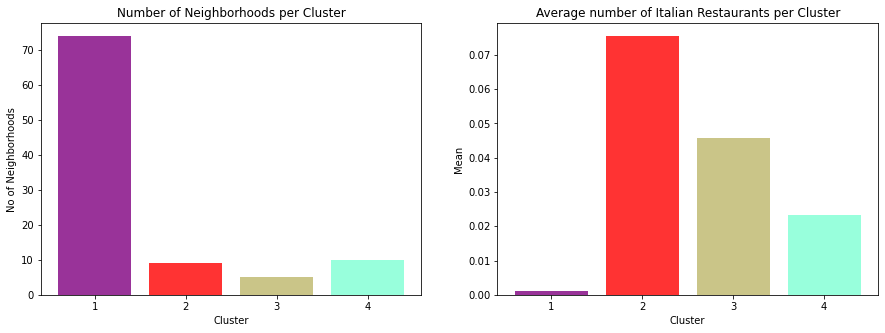

In [48]:
plt.figure(figsize=(15,5))

# Plot-1 ( Number of Neighborhoods per Cluster )

plt.subplot(1,2,1)
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf_1 = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf_1, align='center', alpha=0.8, color=['purple', 'red', 'darkkhaki', 'aquamarine'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('Number of Neighborhoods per Cluster')

# Plot-2 ( Average number of Italian Restaurants per Cluster )

plt.subplot(1, 2, 2)
clusters_mean = [df_cluster1['Italian Restaurant'].mean(),df_cluster2['Italian Restaurant'].mean(),df_cluster3['Italian Restaurant'].mean(),
                df_cluster4['Italian Restaurant'].mean()]
y_pos = np.arange(len(objects))
perf_2 = clusters_mean
plt.bar(y_pos, perf_2, align='center', alpha=0.8, color=['purple', 'red', 'darkkhaki', 'aquamarine'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Italian Restaurants per Cluster')

## CONCLUSION

The Neighborhoods located in the East Toronto area(cluster-4) have the highest average of Italian Restaurants which is represented by aquamarine colour. North York has second heighest number of Italian restaurants present. Looking at the nearby venues, the optimum place to put a new Italian Restaurant is in Victoria village,North York(cluster-2) as their are many Neighborhoods in that area but a little number of Italian Restaurants therefore, eliminating any competition.The second best Neighborhoods that have a great oppurtunity would be in areas such as Queen's Park which is in Cluster 3.Having 70 neighborhoods in the area with no Italian Restaurants gives a good oppurtunity for opening up a new restaurant. This concludes the optimal findings for this project and recommends the entrepreneur to open an authentic Italian restaurant in these locations with little to no competition. Nonetheless, if the food is authentic, affordable and good taste, I am confident that it will have great following everywhere.

Here we take an Italian Restaurant as an example. We can do the same process to find the best place or neighborhood

* to open a start up company
* to stay on rent for bachelors
* to start a side business for middle class people
* to open a camp for any kind of servey
* to release a new product for checking the success rate

## Future Work

* Apply different types of clustering algorithms to cluster the neighborhoods.
* Consider other food vanues,market area etc. as features for clustering.
* Consider more then 100 vanues in a neighborhood for analysis using Foursquare api.
